In [152]:
import pickle, tempfile
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_svmlight_file
from sklearn import svm
from nltk.parse import DependencyGraph, DependencyEvaluator
from nltk.parse.transitionparser import TransitionParser, Configuration, Transition
from os import remove
from copy import deepcopy
from operator import itemgetter
from numpy import array
from scipy import sparse
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

### Loading training and testing dependency graphs

In [153]:
train_dg = DependencyGraph().load('./UD_Hindi/hi-ud-train.conllu')
test_dg = DependencyGraph().load('./UD_Hindi/hi-ud-test.conllu')

/home/vivek/anaconda3/lib/python3.6/site-packages/nltk/parse/dependencygraph.py:380: UserWarning: The graph doesn't contain a node that depends on the root element.
  "The graph doesn't contain a node "


In [154]:
class modifiedConfiguration(Configuration):
    def extract_features(self, include_features):
        result = []
        if len(self.stack) > 0:
            # Stack 0
            stack_idx0 = self.stack[len(self.stack) - 1]
            token = self._tokens[stack_idx0]
            if self._check_informative(token['word'], True):
                if include_features['word']:
                    result.append('STK_0_FORM_' + token['word'])
                else:
                    result.append('STK_0_FORM_' + '#')
            if 'lemma' in token and self._check_informative(token['lemma']):
                if include_features['lemma']:
                    result.append('STK_0_LEMMA_' + token['lemma'])
                else:
                    result.append('STK_0_LEMMA_' + '#')
            if self._check_informative(token['tag']):
                if include_features['tag']:
                    result.append('STK_0_POS_' + token['tag'])
                else:
                    result.append('STK_0_POS_' + '#')
            if 'feats' in token and self._check_informative(token['feats']):
                feats = token['feats'].split("|")
                if include_features['feats']:
                    for feat in feats:
                        result.append('STK_0_FEATS_' + feat)
                else:
                    result.append('STK_0_FEATS_' + '#')
            
            # Stack 1
            if len(self.stack) > 1:
                stack_idx1 = self.stack[len(self.stack) - 2]
                token = self._tokens[stack_idx1]
                if self._check_informative(token['tag']):
                    if include_features['tag']:
                        result.append('STK_1_POS_' + token['tag'])
                    else:
                        result.append('STK_1_POS_' + '#')
            # Left most, right most dependency of stack[0]
            left_most = 1000000
            right_most = -1
            dep_left_most = ''
            dep_right_most = ''
            for (wi, r, wj) in self.arcs:
                if wi == stack_idx0:
                    if (wj > wi) and (wj > right_most):
                        right_most = wj
                        dep_right_most = r
                    if (wj < wi) and (wj < left_most):
                        left_most = wj
                        dep_left_most = r
            if self._check_informative(dep_left_most):
                result.append('STK_0_LDEP_' + dep_left_most)
            if self._check_informative(dep_right_most):
                result.append('STK_0_RDEP_' + dep_right_most)

        # Check Buffered 0
        if len(self.buffer) > 0:
            # Buffer 0
            buffer_idx0 = self.buffer[0]
            token = self._tokens[buffer_idx0]
            if self._check_informative(token['word'], True):
                if include_features['word']:
                    result.append('BUF_0_FORM_' + token['word'])
                else:
                    result.append('BUF_0_FORM_' + '#')
            if 'lemma' in token and self._check_informative(token['lemma']):
                if include_features['lemma']:
                    result.append('BUF_0_LEMMA_' + token['lemma'])
                else:
                    result.append('BUF_0_LEMMA_' + '#')
            if self._check_informative(token['tag']):
                if include_features['tag']:
                    result.append('BUF_0_POS_' + token['tag'])
                else:
                    result.append('BUF_0_POS_' + '#')
            if 'feats' in token and self._check_informative(token['feats']):
                feats = token['feats'].split("|")
                if include_features['feats']:
                    for feat in feats:
                        result.append('BUF_0_FEATS_' + feat)
                else:
                    result.append('BUF_0_FEATS_' + '#')
            # Buffer 1
            if len(self.buffer) > 1:
                buffer_idx1 = self.buffer[1]
                token = self._tokens[buffer_idx1]
                if self._check_informative(token['word'], True):
                    if include_features['word']:
                        result.append('BUF_1_FORM_' + token['word'])
                    else:
                        result.append('BUF_1_FORM_' + '#')
                if self._check_informative(token['tag']):
                    if include_features['tag']:
                        result.append('BUF_1_POS_' + token['tag'])
                    else:
                        result.append('BUF_1_POS_' + '#')
            if len(self.buffer) > 2:
                buffer_idx2 = self.buffer[2]
                token = self._tokens[buffer_idx2]
                if self._check_informative(token['tag']):
                    if include_features['tag']:
                        result.append('BUF_2_POS_' + token['tag'])
                    else:
                        result.append('BUF_2_POS_' + '#')
            if len(self.buffer) > 3:
                buffer_idx3 = self.buffer[3]
                token = self._tokens[buffer_idx3]
                if self._check_informative(token['tag']):
                    if include_features['tag']:
                        result.append('BUF_3_POS_' + token['tag'])
                    else:
                        result.append('BUF_3_POS_' + '#')
                    # Left most, right most dependency of stack[0]
            left_most = 1000000
            right_most = -1
            dep_left_most = ''
            dep_right_most = ''
            for (wi, r, wj) in self.arcs:
                if wi == buffer_idx0:
                    if (wj > wi) and (wj > right_most):
                        right_most = wj
                        dep_right_most = r
                    if (wj < wi) and (wj < left_most):
                        left_most = wj
                        dep_left_most = r
            if self._check_informative(dep_left_most):
                result.append('BUF_0_LDEP_' + dep_left_most)
            if self._check_informative(dep_right_most):
                result.append('BUF_0_RDEP_' + dep_right_most)

        return result

In [155]:
class modifiedTransitionParser(TransitionParser):
    def _create_training_examples_arc_std(self, depgraphs, input_file, include_features):
        operation = Transition(self.ARC_STANDARD)
        count_proj = 0
        training_seq = []

        for depgraph in depgraphs:
            if not self._is_projective(depgraph):
                continue

            count_proj += 1
            conf = modifiedConfiguration(depgraph)
            while len(conf.buffer) > 0:
                b0 = conf.buffer[0]
                features = conf.extract_features(include_features)
                binary_features = self._convert_to_binary_features(features)

                if len(conf.stack) > 0:
                    s0 = conf.stack[len(conf.stack) - 1]
                    # Left-arc operation
                    rel = self._get_dep_relation(b0, s0, depgraph)
                    if rel is not None:
                        key = Transition.LEFT_ARC + ':' + rel
                        self._write_to_file(key, binary_features, input_file)
                        operation.left_arc(conf, rel)
                        training_seq.append(key)
                        continue

                    # Right-arc operation
                    rel = self._get_dep_relation(s0, b0, depgraph)
                    if rel is not None:
                        precondition = True
                        # Get the max-index of buffer
                        maxID = conf._max_address

                        for w in range(maxID + 1):
                            if w != b0:
                                relw = self._get_dep_relation(b0, w, depgraph)
                                if relw is not None:
                                    if (b0, relw, w) not in conf.arcs:
                                        precondition = False

                        if precondition:
                            key = Transition.RIGHT_ARC + ':' + rel
                            self._write_to_file(
                                key,
                                binary_features,
                                input_file)
                            operation.right_arc(conf, rel)
                            training_seq.append(key)
                            continue

                # Shift operation as the default
                key = Transition.SHIFT
                self._write_to_file(key, binary_features, input_file)
                operation.shift(conf)
                training_seq.append(key)

        print(" Number of training examples : " + str(len(depgraphs)))
        print(" Number of valid (projective) examples : " + str(count_proj))
        return training_seq
    
    def _create_training_examples_arc_eager(self, depgraphs, input_file, include_features):
        """
        Create the training example in the libsvm format and write it to the input_file.
        Reference : 'A Dynamic Oracle for Arc-Eager Dependency Parsing' by Joav Goldberg and Joakim Nivre
        """
        operation = Transition(self.ARC_EAGER)
        countProj = 0
        training_seq = []

        for depgraph in depgraphs:
            if not self._is_projective(depgraph):
                continue

            countProj += 1
            conf = modifiedConfiguration(depgraph)
            while len(conf.buffer) > 0:
                b0 = conf.buffer[0]
                features = conf.extract_features(include_features)
                binary_features = self._convert_to_binary_features(features)

                if len(conf.stack) > 0:
                    s0 = conf.stack[len(conf.stack) - 1]
                    # Left-arc operation
                    rel = self._get_dep_relation(b0, s0, depgraph)
                    if rel is not None:
                        key = Transition.LEFT_ARC + ':' + rel
                        self._write_to_file(key, binary_features, input_file)
                        operation.left_arc(conf, rel)
                        training_seq.append(key)
                        continue

                    # Right-arc operation
                    rel = self._get_dep_relation(s0, b0, depgraph)
                    if rel is not None:
                        key = Transition.RIGHT_ARC + ':' + rel
                        self._write_to_file(key, binary_features, input_file)
                        operation.right_arc(conf, rel)
                        training_seq.append(key)
                        continue

                    # reduce operation
                    flag = False
                    for k in range(s0):
                        if self._get_dep_relation(k, b0, depgraph) is not None:
                            flag = True
                        if self._get_dep_relation(b0, k, depgraph) is not None:
                            flag = True
                    if flag:
                        key = Transition.REDUCE
                        self._write_to_file(key, binary_features, input_file)
                        operation.reduce(conf)
                        training_seq.append(key)
                        continue

                # Shift operation as the default
                key = Transition.SHIFT
                self._write_to_file(key, binary_features, input_file)
                operation.shift(conf)
                training_seq.append(key)

        print(" Number of training examples : " + str(len(depgraphs)))
        print(" Number of valid (projective) examples : " + str(countProj))
        return training_seq
    
    def train(self, depgraphs, modelfile, include_features, modeltype, verbose=True):
        """
        :param depgraphs : list of DependencyGraph as the training data
        :type depgraphs : DependencyGraph
        :param modelfile : file name to save the trained model
        :type modelfile : str
        """

        try:
            input_file = tempfile.NamedTemporaryFile(
                prefix='transition_parse.train',
                dir=tempfile.gettempdir(),
                delete=False)

            if self._algorithm == self.ARC_STANDARD:
                self._create_training_examples_arc_std(depgraphs, input_file, include_features)
            else:
                self._create_training_examples_arc_eager(depgraphs, input_file, include_features)

            input_file.close()
            # Using the temporary file to train the libsvm classifier
            x_train, y_train = load_svmlight_file(input_file.name)
            # The parameter is set according to the paper:
            # Algorithms for Deterministic Incremental Dependency Parsing by Joakim Nivre
            # Todo : because of probability = True => very slow due to
            # cross-validation. Need to improve the speed here
            if modeltype=='mlp':
                model = MLPClassifier()
            elif modeltype == 'logistic_reg':
                model = LogisticRegression()
            elif modeltype == 'svm':
                model = svm.SVC(
                    kernel='poly',
                    degree=2,
                    coef0=0,
                    gamma=0.2,
                    C=0.5,
                    verbose=verbose,
                    probability=True)
                
            model.fit(x_train, y_train.ravel())
            # Save the model to file name (as pickle)
            pickle.dump(model, open(modelfile, 'wb'))
        finally:
            remove(input_file.name)
            
    def parse(self, depgraphs, modelFile, include_features):
        """
        :param depgraphs: the list of test sentence, each sentence is represented as a dependency graph where the 'head' information is dummy
        :type depgraphs: list(DependencyGraph)
        :param modelfile: the model file
        :type modelfile: str
        :return: list (DependencyGraph) with the 'head' and 'rel' information
        """
        result = []
        # First load the model
        model = pickle.load(open(modelFile, 'rb'))
        operation = Transition(self._algorithm)

        for depgraph in depgraphs:
            conf = modifiedConfiguration(depgraph)
            while len(conf.buffer) > 0:
                features = conf.extract_features(include_features)
                col = []
                row = []
                data = []
                for feature in features:
                    if feature in self._dictionary:
                        col.append(self._dictionary[feature])
                        row.append(0)
                        data.append(1.0)
                np_col = array(sorted(col))  # NB : index must be sorted
                np_row = array(row)
                np_data = array(data)

                x_test = sparse.csr_matrix((np_data, (np_row, np_col)), shape=(1, len(self._dictionary)))
                prob_dict = {}
                pred_prob = model.predict_proba(x_test)[0]
                for i in range(len(pred_prob)):
                    prob_dict[i] = pred_prob[i]
                sorted_Prob = sorted(
                    prob_dict.items(),
                    key=itemgetter(1),
                    reverse=True)

                # Note that SHIFT is always a valid operation
                for (y_pred_idx, confidence) in sorted_Prob:
                    #y_pred = model.predict(x_test)[0]
                    # From the prediction match to the operation
                    y_pred = model.classes_[y_pred_idx]

                    if y_pred in self._match_transition:
                        strTransition = self._match_transition[y_pred]
                        baseTransition = strTransition.split(":")[0]

                        if baseTransition == Transition.LEFT_ARC:
                            if operation.left_arc(conf, strTransition.split(":")[1]) != -1:
                                break
                        elif baseTransition == Transition.RIGHT_ARC:
                            if operation.right_arc(conf, strTransition.split(":")[1]) != -1:
                                break
                        elif baseTransition == Transition.REDUCE:
                            if operation.reduce(conf) != -1:
                                break
                        elif baseTransition == Transition.SHIFT:
                            if operation.shift(conf) != -1:
                                break
                    else:
                        raise ValueError("The predicted transition is not recognized, expected errors")

            # Finish with operations build the dependency graph from Conf.arcs

            new_depgraph = deepcopy(depgraph)
            for key in new_depgraph.nodes:
                node = new_depgraph.nodes[key]
                node['rel'] = ''
                # With the default, all the token depend on the Root
                node['head'] = 0
            for (head, rel, child) in conf.arcs:
                c_node = new_depgraph.nodes[child]
                c_node['head'] = head
                c_node['rel'] = rel
            result.append(new_depgraph)

        return result            

## Arc - standard transition
### 1. SVC

In [156]:
# all features
include_features = {'word': True,'lemma': True,'tag': True,'feats':True}
parser_std = modifiedTransitionParser('arc-standard')
parser_std.train(train_dg,'svm-1.arcstd.model',include_features,'svm',verbose=False)

result = parser_std.parse(test_dg ,'svm-1.arcstd.model', include_features)
de_svc_1 = DependencyEvaluator(result, test_dg)
print('Arc Standard Transition | SVC | All features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_svc_1.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_svc_1.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Standard Transition | SVC | All features
Labeled Attachment Score   : 0.8609
Unlabeled Attachment Score : 0.7702


In [157]:
# without morphological features
include_features = {'word': True,'lemma': True,'tag': True,'feats':False}
parser_std = modifiedTransitionParser('arc-standard')
parser_std.train(train_dg,'svm-2.arcstd.model',include_features,'svm',verbose=False)

result = parser_std.parse(test_dg ,'svm-2.arcstd.model', include_features)
de_svc_2 = DependencyEvaluator(result, test_dg)
print('Arc Standard Transition | SVC | w/o morphological features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_svc_2.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_svc_2.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Standard Transition | SVC | w/o morphological features
Labeled Attachment Score   : 0.8443
Unlabeled Attachment Score : 0.7589


In [158]:
# without word features
include_features = {'word': False,'lemma': True,'tag': True,'feats':True}
parser_std = modifiedTransitionParser('arc-standard')
parser_std.train(train_dg,'svm-3.arcstd.model',include_features,'svm',verbose=False)

result = parser_std.parse(test_dg ,'svm-3.arcstd.model', include_features)
de_svc_3 = DependencyEvaluator(result, test_dg)
print('Arc Standard Transition | SVC | w/o word features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_svc_3.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_svc_3.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Standard Transition | SVC | w/o word features
Labeled Attachment Score   : 0.8556
Unlabeled Attachment Score : 0.7642


In [159]:
# without lemma features
include_features = {'word': True,'lemma': False,'tag': True,'feats':True}
parser_std = modifiedTransitionParser('arc-standard')
parser_std.train(train_dg,'svm-4.arcstd.model',include_features,'svm',verbose=False)

result = parser_std.parse(test_dg ,'svm-4.arcstd.model', include_features)
de_svc_4 = DependencyEvaluator(result, test_dg)
print('Arc Standard Transition | SVC | w/o lemma features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_svc_4.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_svc_4.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Standard Transition | SVC | w/o lemma features
Labeled Attachment Score   : 0.8594
Unlabeled Attachment Score : 0.7664


In [160]:
# without PoS features
include_features = {'word': True,'lemma': True,'tag': False,'feats':True}
parser_std = modifiedTransitionParser('arc-standard')
parser_std.train(train_dg,'svm-5.arcstd.model',include_features,'svm',verbose=False)

result = parser_std.parse(test_dg ,'svm-5.arcstd.model', include_features)
de_svc_5 = DependencyEvaluator(result, test_dg)
print('Arc Standard Transition | SVC | w/o PoS features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_svc_5.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_svc_5.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Standard Transition | SVC | w/o PoS features
Labeled Attachment Score   : 0.8095
Unlabeled Attachment Score : 0.7105


### 2. Logistic Regression

In [161]:
# all features
include_features = {'word': True,'lemma': True,'tag': True,'feats':True}
parser_std = modifiedTransitionParser('arc-standard')
parser_std.train(train_dg,'logreg-1.arcstd.model',include_features,'logistic_reg',verbose=False)

result = parser_std.parse(test_dg ,'logreg-1.arcstd.model', include_features)
de_logreg_1 = DependencyEvaluator(result, test_dg)
print('Arc Standard Transition | Logistic Regression | All features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_logreg_1.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_logreg_1.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Standard Transition | Logistic Regression | All features
Labeled Attachment Score   : 0.8035
Unlabeled Attachment Score : 0.6893


In [162]:
# without morphological features
include_features = {'word': True,'lemma': True,'tag': True,'feats':False}
parser_std = modifiedTransitionParser('arc-standard')
parser_std.train(train_dg,'logreg-2.arcstd.model',include_features,'logistic_reg',verbose=False)

result = parser_std.parse(test_dg ,'logreg-2.arcstd.model', include_features)
de_logreg_2 = DependencyEvaluator(result, test_dg)
print('Arc Standard Transition | Logistic Regression | w/o morphological features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_logreg_2.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_logreg_2.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Standard Transition | Logistic Regression | w/o morphological features
Labeled Attachment Score   : 0.7967
Unlabeled Attachment Score : 0.6901


In [163]:
# w/o word features
include_features = {'word': False,'lemma': True,'tag': True,'feats':True}
parser_std = modifiedTransitionParser('arc-standard')
parser_std.train(train_dg,'logreg-3.arcstd.model',include_features,'logistic_reg',verbose=False)

result = parser_std.parse(test_dg ,'logreg-3.arcstd.model', include_features)
de_logreg_3 = DependencyEvaluator(result, test_dg)
print('Arc Standard Transition | Logistic Regression | w/o word features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_logreg_3.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_logreg_3.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Standard Transition | Logistic Regression | w/o word features
Labeled Attachment Score   : 0.8073
Unlabeled Attachment Score : 0.7029


In [164]:
# w/o lemma features
include_features = {'word': True,'lemma': False,'tag': True,'feats':True}
parser_std = modifiedTransitionParser('arc-standard')
parser_std.train(train_dg,'logreg-4.arcstd.model',include_features,'logistic_reg',verbose=False)

result = parser_std.parse(test_dg ,'logreg-4.arcstd.model', include_features)
de_logreg_4 = DependencyEvaluator(result, test_dg)
print('Arc Standard Transition | Logistic Regression | w/o lemma features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_logreg_4.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_logreg_4.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Standard Transition | Logistic Regression | w/o lemma features
Labeled Attachment Score   : 0.8133
Unlabeled Attachment Score : 0.7007


In [165]:
# w/o PoS features
include_features = {'word': True,'lemma': True,'tag': False,'feats':True}
parser_std = modifiedTransitionParser('arc-standard')
parser_std.train(train_dg,'logreg-5.arcstd.model',include_features,'logistic_reg',verbose=False)

result = parser_std.parse(test_dg ,'logreg-5.arcstd.model', include_features)
de_logreg_5 = DependencyEvaluator(result, test_dg)
print('Arc Standard Transition | Logistic Regression | w/o PoS features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_logreg_5.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_logreg_5.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Standard Transition | Logistic Regression | w/o PoS features
Labeled Attachment Score   : 0.7702
Unlabeled Attachment Score : 0.6682


### 3. Multilayer Perceptron

In [166]:
# all features
include_features = {'word': True,'lemma': True,'tag': True,'feats':True}
parser_std = modifiedTransitionParser('arc-standard')
parser_std.train(train_dg,'mlp-1.arcstd.model',include_features,'mlp',verbose=False)

result = parser_std.parse(test_dg ,'mlp-1.arcstd.model', include_features)
de_mlp_1 = DependencyEvaluator(result, test_dg)
print('Arc Standard Transition | MLP | All features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_mlp_1.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_mlp_1.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Standard Transition | MLP | All features
Labeled Attachment Score   : 0.8065
Unlabeled Attachment Score : 0.6999


In [167]:
# w/o morphological features
include_features = {'word': True,'lemma': True,'tag': True,'feats':False}
parser_std = modifiedTransitionParser('arc-standard')
parser_std.train(train_dg,'mlp-2.arcstd.model',include_features,'mlp',verbose=False)

result = parser_std.parse(test_dg ,'mlp-2.arcstd.model', include_features)
de_mlp_2 = DependencyEvaluator(result, test_dg)
print('Arc Standard Transition | MLP | w/o morphological features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_mlp_2.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_mlp_2.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Standard Transition | MLP | w/o morphological features
Labeled Attachment Score   : 0.8080
Unlabeled Attachment Score : 0.6939


In [168]:
# w/o word features
include_features = {'word': False,'lemma': True,'tag': True,'feats':True}
parser_std = modifiedTransitionParser('arc-standard')
parser_std.train(train_dg,'mlp-3.arcstd.model',include_features,'mlp',verbose=False)

result = parser_std.parse(test_dg ,'mlp-3.arcstd.model', include_features)
de_mlp_3 = DependencyEvaluator(result, test_dg)
print('Arc Standard Transition | MLP | w/o word features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_mlp_3.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_mlp_3.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Standard Transition | MLP | w/o word features
Labeled Attachment Score   : 0.8156
Unlabeled Attachment Score : 0.7052


In [169]:
# w/o lemma features
include_features = {'word': True,'lemma': False,'tag': True,'feats':True}
parser_std = modifiedTransitionParser('arc-standard')
parser_std.train(train_dg,'mlp-4.arcstd.model',include_features,'mlp',verbose=False)

result = parser_std.parse(test_dg ,'mlp-4.arcstd.model', include_features)
de_mlp_4 = DependencyEvaluator(result, test_dg)
print('Arc Standard Transition | MLP | w/o lemma features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_mlp_4.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_mlp_4.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Standard Transition | MLP | w/o lemma features
Labeled Attachment Score   : 0.8201
Unlabeled Attachment Score : 0.7113


In [170]:
# w/o PoS features
include_features = {'word': True,'lemma': True,'tag': False,'feats':True}
parser_std = modifiedTransitionParser('arc-standard')
parser_std.train(train_dg,'mlp-5.arcstd.model',include_features,'mlp',verbose=False)

result = parser_std.parse(test_dg ,'mlp-5.arcstd.model', include_features)
de_mlp_5 = DependencyEvaluator(result, test_dg)
print('Arc Standard Transition | MLP | w/o PoS features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_mlp_5.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_mlp_5.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Standard Transition | MLP | w/o PoS features
Labeled Attachment Score   : 0.7543
Unlabeled Attachment Score : 0.6402


/home/vivek/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


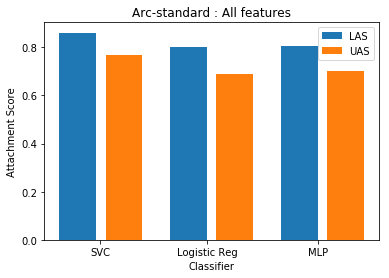

In [171]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
rects1 = ax.bar([0,0.6,1.2],[t.eval()[0] for t in [de_svc_1,de_logreg_1,de_mlp_1]], 0.2)
rects2 = ax.bar([0.25,0.85,1.45],[t.eval()[1] for t in [de_svc_1,de_logreg_1,de_mlp_1]], 0.2)
ax.legend((rects1[0], rects2[0]), ('LAS', 'UAS'))
plt.ylabel('Attachment Score')
plt.xlabel('Classifier')
plt.xticks([0.12,0.7,1.3],['SVC','Logistic Reg','MLP'])
plt.title('Arc-standard : All features')
plt.legend()
plt.show()

## Arc - eager transition
### 1. SVC

In [172]:
# all features
include_features = {'word': True,'lemma': True,'tag': True,'feats':True}
parser_egr = modifiedTransitionParser('arc-eager')
parser_egr.train(train_dg,'svm-1.arcegr.model',include_features,'svm',verbose=False)

result = parser_egr.parse(test_dg ,'svm-1.arcegr.model', include_features)
de_svc_ag_1 = DependencyEvaluator(result, test_dg)
print('Arc Eager Transition | SVC | All features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_svc_ag_1.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_svc_ag_1.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Eager Transition | SVC | All features
Labeled Attachment Score   : 0.8828
Unlabeled Attachment Score : 0.7929


In [173]:
# without morphological features
include_features = {'word': True,'lemma': True,'tag': True,'feats':False}
parser_egr = modifiedTransitionParser('arc-eager')
parser_egr.train(train_dg,'svm-2.arcegr.model',include_features,'svm',verbose=False)

result = parser_egr.parse(test_dg ,'svm-2.arcegr.model', include_features)
de_svc_ag_2 = DependencyEvaluator(result, test_dg)
print('Arc Eager Transition | SVC | w/o morphological features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_svc_ag_2.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_svc_ag_2.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Eager Transition | SVC | w/o morphological features
Labeled Attachment Score   : 0.8813
Unlabeled Attachment Score : 0.7831


In [174]:
# w/o word features
include_features = {'word': False,'lemma': True,'tag': True,'feats':True}
parser_egr = modifiedTransitionParser('arc-eager')
parser_egr.train(train_dg,'svm-3.arcegr.model',include_features,'svm',verbose=False)

result = parser_egr.parse(test_dg ,'svm-3.arcegr.model', include_features)
de_svc_ag_3 = DependencyEvaluator(result, test_dg)
print('Arc Eager Transition | SVC | w/o word features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_svc_ag_3.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_svc_ag_3.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Eager Transition | SVC | w/o word features
Labeled Attachment Score   : 0.8783
Unlabeled Attachment Score : 0.7876


In [175]:
# w/o lemma features
include_features = {'word': True,'lemma': False,'tag': True,'feats':True}
parser_egr = modifiedTransitionParser('arc-eager')
parser_egr.train(train_dg,'svm-4.arcegr.model',include_features,'svm',verbose=False)

result = parser_egr.parse(test_dg ,'svm-4.arcegr.model', include_features)
de_svc_ag_4 = DependencyEvaluator(result, test_dg)
print('Arc Eager Transition | SVC | w/o lemma features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_svc_ag_4.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_svc_ag_4.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Eager Transition | SVC | w/o lemma features
Labeled Attachment Score   : 0.8828
Unlabeled Attachment Score : 0.7861


In [176]:
# w/o PoS features
include_features = {'word': True,'lemma': True,'tag': False,'feats':True}
parser_egr = modifiedTransitionParser('arc-eager')
parser_egr.train(train_dg,'svm-5.arcegr.model',include_features,'svm',verbose=False)

result = parser_egr.parse(test_dg ,'svm-5.arcegr.model', include_features)
de_svc_ag_5 = DependencyEvaluator(result, test_dg)
print('Arc Eager Transition | SVC | w/o PoS features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_svc_ag_5.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_svc_ag_5.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Eager Transition | SVC | w/o PoS features
Labeled Attachment Score   : 0.8382
Unlabeled Attachment Score : 0.7286


### 2. Logistic Regression

In [177]:
# all features
include_features = {'word': True,'lemma': True,'tag': True,'feats':True}
parser_egr = modifiedTransitionParser('arc-eager')
parser_egr.train(train_dg,'logreg-1.arcegr.model',include_features,'logistic_reg',verbose=False)

result = parser_egr.parse(test_dg ,'logreg-1.arcegr.model', include_features)
de_logreg_ag_1 = DependencyEvaluator(result, test_dg)
print('Arc Eager Transition | Logistic Regression | All features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_logreg_ag_1.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_logreg_ag_1.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Eager Transition | Logistic Regression | All features
Labeled Attachment Score   : 0.8617
Unlabeled Attachment Score : 0.7513


In [178]:
# w/o morphological features
include_features = {'word': True,'lemma': True,'tag': True,'feats':False}
parser_egr = modifiedTransitionParser('arc-eager')
parser_egr.train(train_dg,'logreg-2.arcegr.model',include_features,'logistic_reg',verbose=False)

result = parser_egr.parse(test_dg ,'logreg-2.arcegr.model', include_features)
de_logreg_ag_2 = DependencyEvaluator(result, test_dg)
print('Arc Eager Transition | Logistic Regression | w/o morphological features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_logreg_ag_2.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_logreg_ag_2.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Eager Transition | Logistic Regression | w/o morphological features
Labeled Attachment Score   : 0.8443
Unlabeled Attachment Score : 0.7271


In [179]:
# w/o word features
include_features = {'word': False,'lemma': True,'tag': True,'feats':True}
parser_egr = modifiedTransitionParser('arc-eager')
parser_egr.train(train_dg,'logreg-3.arcegr.model',include_features,'logistic_reg',verbose=False)

result = parser_egr.parse(test_dg ,'logreg-3.arcegr.model', include_features)
de_logreg_ag_3 = DependencyEvaluator(result, test_dg)
print('Arc Eager Transition | Logistic Regression | w/o word features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_logreg_ag_3.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_logreg_ag_3.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Eager Transition | Logistic Regression | w/o word features
Labeled Attachment Score   : 0.8549
Unlabeled Attachment Score : 0.7475


In [180]:
# w/o lemma features
include_features = {'word': True,'lemma': False,'tag': True,'feats':True}
parser_egr = modifiedTransitionParser('arc-eager')
parser_egr.train(train_dg,'logreg-4.arcegr.model',include_features,'logistic_reg',verbose=False)

result = parser_egr.parse(test_dg ,'logreg-4.arcegr.model', include_features)
de_logreg_ag_4 = DependencyEvaluator(result, test_dg)
print('Arc Eager Transition | Logistic Regression | w/o lemma features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_logreg_ag_4.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_logreg_ag_4.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Eager Transition | Logistic Regression | w/o lemma features
Labeled Attachment Score   : 0.8556
Unlabeled Attachment Score : 0.7407


In [181]:
# w/o PoS features
include_features = {'word': True,'lemma': True,'tag': False,'feats':True}
parser_egr = modifiedTransitionParser('arc-eager')
parser_egr.train(train_dg,'logreg-5.arcegr.model',include_features,'logistic_reg',verbose=False)

result = parser_egr.parse(test_dg ,'logreg-5.arcegr.model', include_features)
de_logreg_ag_5 = DependencyEvaluator(result, test_dg)
print('Arc Eager Transition | Logistic Regression | w/o PoS features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_logreg_ag_5.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_logreg_ag_5.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Eager Transition | Logistic Regression | w/o PoS features
Labeled Attachment Score   : 0.8178
Unlabeled Attachment Score : 0.7082


### 3. Multilayer Perceptron

In [182]:
# all features
include_features = {'word': True,'lemma': True,'tag': True,'feats':True}
parser_egr = modifiedTransitionParser('arc-eager')
parser_egr.train(train_dg,'mlp-1.arcegr.model',include_features,'mlp',verbose=False)

result = parser_egr.parse(test_dg ,'mlp-1.arcegr.model', include_features)
de_mlp_ag_1 = DependencyEvaluator(result, test_dg)
print('Arc Eager Transition | MLP | All features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_mlp_ag_1.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_mlp_ag_1.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Eager Transition | MLP | All features
Labeled Attachment Score   : 0.8405
Unlabeled Attachment Score : 0.7354


In [183]:
# w/o morphological features
include_features = {'word': True,'lemma': True,'tag': True,'feats':False}
parser_egr = modifiedTransitionParser('arc-eager')
parser_egr.train(train_dg,'mlp-2.arcegr.model',include_features,'mlp',verbose=False)

result = parser_egr.parse(test_dg ,'mlp-2.arcegr.model', include_features)
de_mlp_ag_2 = DependencyEvaluator(result, test_dg)
print('Arc Eager Transition | MLP | w/o morphological features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_mlp_ag_2.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_mlp_ag_2.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Eager Transition | MLP | w/o morphological features
Labeled Attachment Score   : 0.8443
Unlabeled Attachment Score : 0.7264


In [184]:
# w/o word features
include_features = {'word': False,'lemma': True,'tag': True,'feats':True}
parser_egr = modifiedTransitionParser('arc-eager')
parser_egr.train(train_dg,'mlp-3.arcegr.model',include_features,'mlp',verbose=False)

result = parser_egr.parse(test_dg ,'mlp-3.arcegr.model', include_features)
de_mlp_ag_3 = DependencyEvaluator(result, test_dg)
print('Arc Eager Transition | MLP | w/o word features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_mlp_ag_3.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_mlp_ag_3.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Eager Transition | MLP | w/o word features
Labeled Attachment Score   : 0.8602
Unlabeled Attachment Score : 0.7475


In [185]:
# w/o lemma features
include_features = {'word': True,'lemma': False,'tag': True,'feats':True}
parser_egr = modifiedTransitionParser('arc-eager')
parser_egr.train(train_dg,'mlp-4.arcegr.model',include_features,'mlp',verbose=False)

result = parser_egr.parse(test_dg ,'mlp-4.arcegr.model', include_features)
de_mlp_ag_4 = DependencyEvaluator(result, test_dg)
print('Arc Eager Transition | MLP | w/o lemma features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_mlp_ag_4.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_mlp_ag_4.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Eager Transition | MLP | w/o lemma features
Labeled Attachment Score   : 0.8503
Unlabeled Attachment Score : 0.7392


In [186]:
# w/o PoS features
include_features = {'word': True,'lemma': True,'tag': False,'feats':True}
parser_egr = modifiedTransitionParser('arc-eager')
parser_egr.train(train_dg,'mlp-5.arcegr.model',include_features,'mlp',verbose=False)

result = parser_egr.parse(test_dg ,'mlp-5.arcegr.model', include_features)
de_mlp_ag_5 = DependencyEvaluator(result, test_dg)
print('Arc Eager Transition | MLP | w/o PoS features')
print('Labeled Attachment Score   : {:0.4f}'.format(de_mlp_ag_5.eval()[0]))
print('Unlabeled Attachment Score : {:0.4f}'.format(de_mlp_ag_5.eval()[1]))

 Number of training examples : 500
 Number of valid (projective) examples : 476
Arc Eager Transition | MLP | w/o PoS features
Labeled Attachment Score   : 0.7853
Unlabeled Attachment Score : 0.6788
